# CAB420, Dimension Reduction, Example 3: Linear Discriminant Analysis (LDA)
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Having seen how great PCA is, let's break it. And then make everything better again through Linear Discriminant Analysis. 

## Too Long; Didn't Read
The main take home points from this example are:
* Depending on our task, PCA may not be a good choice. It preserves the total varaince of the data, but this is not necessarily the bit that helps us tell different types of things apart
* LDA kind-of does similar things to PCA - it also computes eigenvalues and eigenvectors, but this time it does so from the ratio of these things called **scatter matrices**. We have two types of scatter matrix:
    * The **within class** scatter matrix captures how each dimension changes within the same class
    * The **between class** scatter matrix captues how they change between classes.
* Ideally, we want our within class scatter as small as possible (points from the same class are tightly bunched) and our between class scatter as big as possible (points from different classes are far away)
* LDA seeks to do this by computing the eigenvalues and vectors on the ratio of these scatter matrices (within/between)
* By tranforming data using LDA, we can find a transform that gives a good low dimensional separation of the classes. Like PCA we can project into this space. Projecting back out of the space to reconstruct the data does not really make sense and doesn't work that well, so this is really a one-way transform.

In [1]:
import numpy
from sklearn import decomposition
import matplotlib.pyplot as plt

## More Made up Data
We're going to create a dataset that's intended to break PCA. It looks pretty mundane, but this will ruin things for us.

This time we're also going to have two classes, and it's the setup of these that will give us grief. Ideally, we'd obviously like to keep our classes separate, and from the plot below we can see that we have a nice big gap between our classes. What could go wrong?

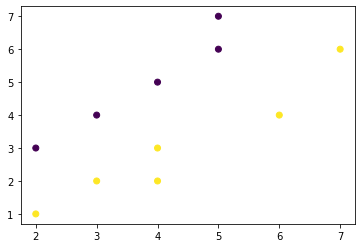

In [2]:
X = numpy.array([[2, 3], [3, 4], [4, 5], [5, 6], [5, 7], [2, 1], [3, 2], [4, 2], [4, 3], [6, 4], [7, 6]])
c = numpy.array([1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=c);

## Breaking PCA
Now let's do our PCA.

In [3]:
pca = decomposition.PCA()
pca.fit(X)
transformed = pca.transform(X)
print(pca.explained_variance_ratio_)

[0.85471369 0.14528631]


Most of the variation is in the first dimension, so let's reduce our data to a single dimension.

In [4]:
reduced_1 = numpy.reshape(transformed[:,0], (-1, 1))
reconstructed_1 = reduced_1.dot(numpy.reshape(pca.components_[0,:], (-1, 1)).transpose()) + pca.mean_
print('Reconstructed:')
print(reconstructed_1[1:10,:])
print('\nActual:')
print(X[1:10,:])
print('\nError: %f' % (numpy.square(X - reconstructed_1)).mean(axis=None))

Reconstructed:
[[3.73842482 3.44234505]
 [4.58253002 4.56007607]
 [5.42663522 5.67780709]
 [5.90755333 6.31462   ]
 [1.9324834  1.05098821]
 [2.7765886  2.16871923]
 [3.13977569 2.64963734]
 [3.6206938  3.28645025]
 [4.82798609 4.88509938]]

Actual:
[[3 4]
 [4 5]
 [5 6]
 [5 7]
 [2 1]
 [3 2]
 [4 2]
 [4 3]
 [6 4]]

Error: 0.408243


Our reconstructions look ok, it all seems fairly close.

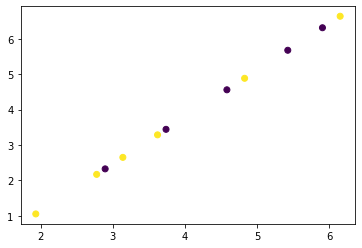

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(reconstructed_1[:,0], reconstructed_1[:,1], c=c);

But from the plot, we can see we have a problem.

Any boundary we had between our classes has vanished. Oddly enough though, if we projected using the second principal component things go a bit different.

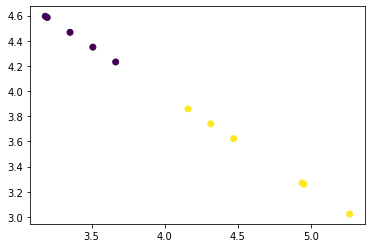

In [6]:
reduced_1 = numpy.reshape(transformed[:,1], (-1, 1))
reconstructed_1 = reduced_1.dot(numpy.reshape(pca.components_[1,:], (-1, 1)).transpose()) + pca.mean_
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(reconstructed_1[:,0], reconstructed_1[:,1], c=c);

We keep our data well separated. This is despite this dimension only containing 15% of the variation. The bottom line is: the dimensions with high variation are not necessarily those that separate classes.

## Scatter Matricies
LDA uses scatter matricies. Let's have a play with them before we go too far. As noted, we have two scatter matrices, the within class:

$S_w = \sum_{i=1}^{n}(x_i-\mu_{y_i})(x_i-\mu_{y_i})^T$

and the between class:

$S_b=\sum_{k=1}^mn_k(\mu_k-\mu)(\mu_k-\mu)^T$

We'll create some new toy data to play with this. Our first example, we'll have three really tight and well separated clusters.

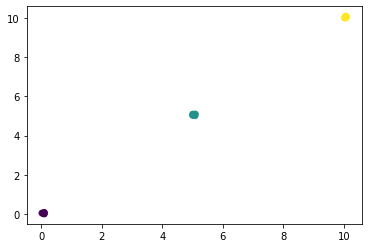

In [7]:
numpy.random.seed(4)
X = numpy.concatenate((numpy.random.uniform(size=(5,2))*0.1, numpy.random.uniform(size=(5,2))*0.1 + 5, numpy.random.uniform(size=(5,2))*0.1 + 10))
c = numpy.array([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=c);

In [8]:
mu_total = numpy.mean(X, axis=0)
c0 = X[c==0, :]
c1 = X[c==1, :]
c2 = X[c==2, :]
mu = numpy.array([numpy.mean(c0, axis=0), numpy.mean(c1, axis=0), numpy.mean(c2, axis=0)])
nk,_ = numpy.histogram(c, 3)
nk = nk.reshape((3,1))

In [9]:
Sw = ((X - mu[c,:]).transpose()).dot((X - mu[c,:]))
print(Sw)

[[0.01331477 0.0015448 ]
 [0.0015448  0.01423041]]


In [10]:
Sb = numpy.multiply(nk, (numpy.ones((3,1))*mu_total - mu)).transpose().dot((numpy.ones((3,1))*mu_total - mu))
print(Sb)

[[248.86709419 249.70285217]
 [249.70285217 250.54892153]]


What we see is:
* within class scatter is very small, i.e. within a single class, points are tightly grouped
* between class scatter is very big, i.e. classes themselves are well seprated

Let's make things a little less well separated and see what happens.

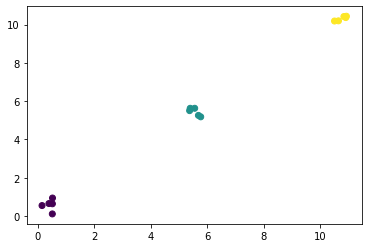

In [11]:
X = numpy.concatenate((numpy.random.uniform(size=(5,2)), numpy.random.uniform(size=(5,2)) + 5, numpy.random.uniform(size=(5,2)) + 10))
c = numpy.array([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=c);

In [12]:
mu_total = numpy.mean(X, axis=0)
c0 = X[c==0, :]
c1 = X[c==1, :]
c2 = X[c==2, :]
mu = numpy.array([numpy.mean(c0, axis=0), numpy.mean(c1, axis=0), numpy.mean(c2, axis=0)])
nk,_ = numpy.histogram(c, 3)
nk = nk.reshape((3,1))

In [13]:
Sw = ((X - mu[c,:]).transpose()).dot((X - mu[c,:]))
print(Sw)

[[ 0.35319307 -0.03366045]
 [-0.03366045  0.59361245]]


In [14]:
Sb = numpy.multiply(nk, (numpy.ones((3,1))*mu_total - mu)).transpose().dot((numpy.ones((3,1))*mu_total - mu))
print(Sb)

[[266.73188433 251.55160505]
 [251.55160505 237.23710806]]


Our within class scatter matrix is now showing our classes aren't as tightly grouped as they were before, but our between class still indicates that classes are well separated, which they are.

Let's go straight to the far extreme, and have clusters that totally overlap.

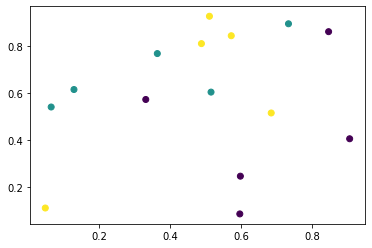

In [15]:
X = numpy.concatenate((numpy.random.uniform(size=(5,2)), numpy.random.uniform(size=(5,2)), numpy.random.uniform(size=(5,2))))
c = numpy.array([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=c);

In [16]:
mu_total = numpy.mean(X, axis=0)
c0 = X[c==0, :]
c1 = X[c==1, :]
c2 = X[c==2, :]
mu = numpy.array([numpy.mean(c0, axis=0), numpy.mean(c1, axis=0), numpy.mean(c2, axis=0)])
nk,_ = numpy.histogram(c, 3)
nk = nk.reshape((3,1))

In [17]:
Sw = ((X - mu[c,:]).transpose()).dot((X - mu[c,:]))
print(Sw)

[[0.74859984 0.41766819]
 [0.41766819 0.89271018]]


In [18]:
Sb = numpy.multiply(nk, (numpy.ones((3,1))*mu_total - mu)).transpose().dot((numpy.ones((3,1))*mu_total - mu))
print(Sb)

[[ 0.22332289 -0.19700407]
 [-0.19700407  0.17936888]]


What we see now is we have high within class scatter (i.e. lots of variation within a class), and low between class scatter (i.e. all of our classes are on top of each other).

## Linear Discriminant Analysis
We want to ensure that we maintain the discriminative power of the data, though to do this, we need class labels. PCA is an unsupervised dimension reduction method, LDA is a supervised method. It achieves it's goal by minimising within-class scatter while maximising between class scatter, this means:
* Keep points in the same class close together
* Keep points in different classes far away

To do this we calcualte the eigenvectors of the ratio of within class scatter to between class scatter.

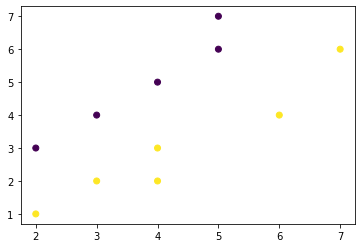

In [19]:
X = numpy.array([[2, 3], [3, 4], [4, 5], [5, 6], [5, 7], [2, 1], [3, 2], [4, 2], [4, 3], [6, 4], [7, 6]])
c = numpy.array([0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=c);
mu_total = numpy.mean(X, axis=0)
c0 = X[c==0, :]
c1 = X[c==1, :]
mu = numpy.array([numpy.mean(c0, axis=0), numpy.mean(c1, axis=0)])
nk,_ = numpy.histogram(c, 2)
nk = nk.reshape((2,1))

Get the within class scatter:

$S_w = \sum_{i=1}^{n}(x_i-\mu_{y_i})(x_i-\mu_{y_i})^T$

In [20]:
Sw = ((X - mu[c,:]).transpose()).dot((X - mu[c,:]))
print(Sw)

[[24.13333333 24.        ]
 [24.         26.        ]]


Get the between class scatter:

$S_b=\sum_{k=1}^mn_k(\mu_k-\mu)(\mu_k-\mu)^T$

In [21]:
Sb = numpy.multiply(nk, (numpy.ones((2,1))*mu_total - mu)).transpose().dot((numpy.ones((2,1))*mu_total - mu))
print(Sb)

[[ 0.77575758 -2.90909091]
 [-2.90909091 10.90909091]]


We want to maximise the ratio between the between and within class scatter matricies, i.e.:

$\hat{\bf{w}}= \underset{w}{argmax}\frac{\bf{w^T}S_b\bf{w}}{\bf{w^T}S_w\bf{w}}$

We can do this via Eigen decomposition. 

In [22]:
eigval, eigvec = numpy.linalg.eig(numpy.linalg.inv(Sw).dot(Sb))
print(eigval)
print(eigvec)

[0.         8.22044277]
[[-0.96623494  0.71169327]
 [-0.25766265 -0.70249034]]


We'll get our eigenvectors into order too. Note that by default numpy's sort will do things in ascending order, so we'll flip that to get descending.

In [23]:
sorted_idx = numpy.flip(numpy.argsort(eigval))
print(sorted_idx)

[1 0]


Let's now project our data into our new space. We'll use just the first component.

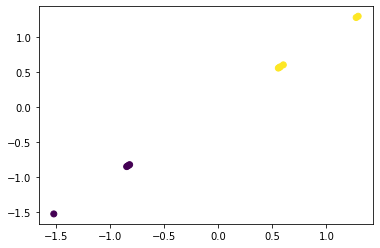

In [24]:
Xm = X - mu_total;
z = Xm.dot(eigvec[:, sorted_idx[0]])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(z, z, c=c);

We can see that we get much better separation between the classes. 

It's worth noting here that while we do get two dimensions back, our second one has an eigenvalue of 0, indicating that it contains no information. While we could project our data into two dimensions using LDA, there is no value in doing so. LDA will only ever give us $C-1$ meaningful dimensions back, where $C$ is the number of classes in our data. In our case, this is 2, so we can only get 1 meaningful dimension. 

Finally, we need to starte that we cannot reconstruct our original data like we can with PCA.